https://www.youtube.com/watch?v=PaCmpygFfXo&t=11s

In [3]:
%cd /code

/code


In [19]:
import torch
import torch.nn.functional as F

words = open('names.txt').read().splitlines()
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [8]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, y_train = build_dataset(words[:n1])
X_dev, y_dev = build_dataset(words[n1:n2])
X_test, y_test = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


---

# Embedding Layer

We have 27 characters, let's try reducing that to a 2-dimensional space (in the paper the authors have 17 words/tokens that they reduce to a 30 dimensional space)

In [63]:
num_characters = len(stoi)
embedding_size = 2

In [64]:
# embedding matrix
C = torch.randn((num_characters, embedding_size))
C

tensor([[ 1.2129,  0.2602],
        [-1.0072, -0.2969],
        [-0.5586, -0.1307],
        [ 0.8953,  0.3645],
        [ 0.2798,  1.1593],
        [-1.2883,  0.5635],
        [-0.2167, -0.5648],
        [ 1.0153,  1.3816],
        [ 1.0944, -0.4452],
        [ 0.5387,  0.2919],
        [ 1.7491,  0.4118],
        [ 0.6236,  0.2790],
        [-0.4863,  0.8271],
        [ 1.0717,  0.7311],
        [-0.1948,  0.7970],
        [-0.0121,  0.7386],
        [-1.2307, -0.7011],
        [-0.0486,  1.3667],
        [-1.3283,  1.2198],
        [ 0.8717,  0.2062],
        [ 0.3393,  0.7667],
        [-0.5255,  0.3516],
        [-1.1593,  0.4251],
        [-1.0949, -1.1169],
        [-1.5504,  0.5990],
        [ 0.3735, -1.4694],
        [-1.6787,  0.0621]])

In [65]:
print(X_train[0:4].shape)
print(X_train[0:4])

torch.Size([4, 3])
tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5,  2],
        [ 5,  2, 18]])


In [66]:
print(C[X_train[0:4]].shape)
print(C[X_train[0:4]])

torch.Size([4, 3, 2])
tensor([[[ 1.2129,  0.2602],
         [ 1.2129,  0.2602],
         [ 1.2129,  0.2602]],

        [[ 1.2129,  0.2602],
         [ 1.2129,  0.2602],
         [-1.2883,  0.5635]],

        [[ 1.2129,  0.2602],
         [-1.2883,  0.5635],
         [-0.5586, -0.1307]],

        [[-1.2883,  0.5635],
         [-0.5586, -0.1307],
         [-1.3283,  1.2198]]])


In [67]:
C[0]

tensor([1.2129, 0.2602])

In [68]:
print(F.one_hot(torch.tensor(0), num_classes=num_characters).float())
print(F.one_hot(torch.tensor(0), num_classes=num_characters).float() @ C)

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([1.2129, 0.2602])


---

# Hidden Layer

In [69]:
# we a matrix of (n, 6) not (n, 3, 2) ; where n is number of samples
embeddings = C[X_train]
print(embeddings.shape)
print(embeddings.view(-1, 6).shape)
print(C[X_train[0:4]])
print(embeddings.view(-1, 6)[0:4])

torch.Size([182580, 3, 2])
torch.Size([182580, 6])
tensor([[[ 1.2129,  0.2602],
         [ 1.2129,  0.2602],
         [ 1.2129,  0.2602]],

        [[ 1.2129,  0.2602],
         [ 1.2129,  0.2602],
         [-1.2883,  0.5635]],

        [[ 1.2129,  0.2602],
         [-1.2883,  0.5635],
         [-0.5586, -0.1307]],

        [[-1.2883,  0.5635],
         [-0.5586, -0.1307],
         [-1.3283,  1.2198]]])
tensor([[ 1.2129,  0.2602,  1.2129,  0.2602,  1.2129,  0.2602],
        [ 1.2129,  0.2602,  1.2129,  0.2602, -1.2883,  0.5635],
        [ 1.2129,  0.2602, -1.2883,  0.5635, -0.5586, -0.1307],
        [-1.2883,  0.5635, -0.5586, -0.1307, -1.3283,  1.2198]])


---

In [70]:
# for example; here are the embeddings (vector of 2 values) for the three characters of context in the 5th example (index 4)
C[X_train[4]]

tensor([[-0.5586, -0.1307],
        [-1.3283,  1.2198],
        [ 0.5387,  0.2919]])

In [71]:
# here is the same example above but as a single vector that we can multiply with our weights
embeddings.view(-1, 6)[4]

tensor([-0.5586, -0.1307, -1.3283,  1.2198,  0.5387,  0.2919])

---

In [72]:
# block_size is basically context size (i.e. # of characters)
# multiplied by the size of the embedding for each character
num_inputs = block_size * C.shape[1]
num_neurons = 100
W1 = torch.randn((num_inputs, num_neurons))
b1 = torch.randn(num_neurons)
print(W1.shape)
print(b1.shape)

torch.Size([6, 100])
torch.Size([100])


In [73]:
print(embeddings.shape)
print(embeddings.view(-1, num_inputs).shape)
print(W1.shape)
print((embeddings.view(-1, num_inputs) @ W1).shape)
print((embeddings.view(-1, num_inputs) @ W1 + b1).shape)

torch.Size([182580, 3, 2])
torch.Size([182580, 6])
torch.Size([6, 100])
torch.Size([182580, 100])
torch.Size([182580, 100])


In [75]:
h = torch.tanh(embeddings.view(-1, num_inputs) @ W1 + b1)
h.shape

torch.Size([182580, 100])

In [76]:
print(h.min())
print(h.max())

tensor(-1.)
tensor(1.)


---

# Final Layer

In [78]:
W2 = torch.randn((num_neurons, num_characters))
b2 = torch.randn(num_characters)

In [79]:
print(h.shape)
print(W2.shape)
print(b2.shape)
logits = h @ W2 + b2
print(logits.shape)
logits

torch.Size([182580, 100])
torch.Size([100, 27])
torch.Size([27])
torch.Size([182580, 27])


tensor([[-2.4750e+00, -3.6773e+00, -2.1217e-01,  ...,  3.7176e+00,
         -4.8292e+00, -7.5542e+00],
        [ 3.0841e-03,  1.9645e+00, -6.8366e-01,  ...,  6.1097e+00,
          1.5478e+00,  4.1243e+00],
        [ 9.8877e+00, -8.5275e+00,  1.4799e+01,  ...,  5.1419e+00,
          1.1409e+01,  4.1999e+00],
        ...,
        [ 7.6402e+00, -5.3688e-01,  6.9159e+00,  ..., -5.0806e+00,
          1.3901e+01,  2.4299e-01],
        [-1.2063e+01,  1.3272e+00,  5.5985e+00,  ..., -1.6562e+00,
          5.7444e+00, -4.4725e+00],
        [-1.4519e+00, -9.0674e+00,  5.6148e+00,  ..., -5.4463e+00,
         -2.3535e+00, -2.7775e+00]])

In [81]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
print(prob.shape)
loss = -prob[torch.arange(X_train.shape[0]), y_train].log().mean()
loss

torch.Size([182580, 27])


tensor(19.5978)

---

# Put it together

In [228]:
num_characters = len(stoi)
context_size = 7 # context length: how many characters do we take to predict the next one?
embedding_size = 10

num_inputs = context_size * embedding_size
num_neurons = 200

In [229]:
# build the dataset
def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * context_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, y_train = build_dataset(words[:n1])
X_dev, y_dev = build_dataset(words[n1:n2])
X_test, y_test = build_dataset(words[n2:])

torch.Size([182441, 7]) torch.Size([182441])
torch.Size([22902, 7]) torch.Size([22902])
torch.Size([22803, 7]) torch.Size([22803])


In [230]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility

# embeddings matrix
C = torch.randn((num_characters, embedding_size), generator=g)
print(C.shape)
W1 = torch.randn((num_inputs, num_neurons), generator=g)
print(W1.shape)
b1 = torch.randn(num_neurons, generator=g)
print(b1.shape)
W2 = torch.randn((num_neurons, num_characters), generator=g)
print(W2.shape)
b2 = torch.randn(num_characters, generator=g)
print(b2.shape)
parameters = [C, W1, b1, W2, b2]

torch.Size([27, 10])
torch.Size([70, 200])
torch.Size([200])
torch.Size([200, 27])
torch.Size([27])


In [231]:
sum(p.nelement() for p in parameters) # number of parameters in total

19897

In [232]:
for p in parameters:
  p.requires_grad = True

In [233]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

(array([668.,  99.,  59.,  41.,  32.,  27.,  22.,  19.,  17.,  16.]),
 array([0.001     , 0.1009    , 0.2008    , 0.30070001, 0.40059999,
        0.50050002, 0.60039997, 0.70029998, 0.80019999, 0.90009999,
        1.        ]),
 <BarContainer object of 10 artists>)

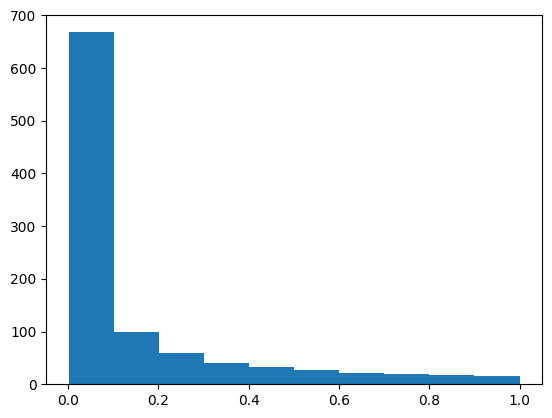

In [326]:
from matplotlib import pyplot as plt
#plt.plot(torch.arange(1000), lrs)
plt.hist(lrs)

In [322]:
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [234]:
lri = []
lossi = []
stepi = []

In [235]:
C

tensor([[ 1.5674e+00, -2.3729e-01, -2.7385e-02, -1.1008e+00,  2.8588e-01,
         -2.9644e-02, -1.5471e+00,  6.0489e-01,  7.9136e-02,  9.0462e-01],
        [-4.7125e-01,  7.8682e-01, -3.2844e-01, -4.3297e-01,  1.3729e+00,
          2.9334e+00,  1.5618e+00, -1.6261e+00,  6.7716e-01, -8.4040e-01],
        [ 9.8488e-01, -1.4837e-01, -1.4795e+00,  4.4830e-01, -7.0731e-02,
          2.4968e+00,  2.4448e+00, -6.7006e-01, -1.2199e+00,  3.0314e-01],
        [-1.0725e+00,  7.2762e-01,  5.1114e-02,  1.3095e+00, -8.0220e-01,
         -8.5042e-01, -1.8068e+00,  1.2523e+00, -1.2256e+00,  1.2165e+00],
        [-9.6478e-01, -2.3211e-01, -3.4762e-01,  3.3244e-01, -1.3263e+00,
          1.1224e+00,  5.9641e-01,  4.5846e-01,  5.4011e-02, -1.7400e+00],
        [ 1.1560e-01,  8.0319e-01,  5.4108e-01, -1.1646e+00,  1.4756e-01,
         -1.0006e+00,  3.8012e-01,  4.7328e-01, -9.1027e-01, -7.8305e-01],
        [ 1.3506e-01, -2.1161e-01, -1.0406e+00, -1.5367e+00,  9.3743e-01,
         -8.8303e-01,  1.7457e+0

In [330]:
y_train[ix]

tensor([14,  7,  1, 19,  1, 13,  3,  1,  1, 18, 21, 14,  4, 20,  1, 18,  9,  1,
         3, 21,  0, 22,  9,  6,  3,  2, 12, 23,  1,  9, 12,  5, 25,  2,  1,  9,
        25, 12, 14,  1,  9,  1, 19,  1,  5, 13,  0, 15,  9,  5,  0,  1,  1, 14,
         0, 14, 23,  9, 25, 20,  0, 14,  5,  1])

In [331]:
logits

tensor([[11.9206,  5.6528,  4.7943,  5.0863,  5.7310,  7.4090,  4.4110,  0.5325,
          8.6380,  5.7993,  4.2375,  4.3242,  6.9594,  6.4541,  8.9456,  3.3343,
          2.6501,  0.6253,  7.5920,  7.2971,  6.4229,  5.4708,  3.8845,  3.5194,
          1.4624,  6.2334,  1.5439]], grad_fn=<AddBackward0>)

In [257]:
batch_size = 64

for i in range(200_000):
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (batch_size,))
  
  # forward pass
  emb = C[X_train[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, num_inputs) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y_train[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

In [258]:
C

tensor([[ 1.8768, -0.1808,  0.1652, -1.4020,  1.1251,  0.7924, -1.5009,  0.4526,
          1.8750,  1.9589],
        [-0.5577,  0.6830, -0.6480, -0.3702,  0.1094,  1.5133,  0.0904,  0.6914,
         -0.1151,  0.1073],
        [-0.2898,  0.3895, -0.5767, -0.9032, -0.4827,  0.9840,  0.2378,  0.9603,
          0.5400,  0.3341],
        [ 0.1038, -0.0903, -0.5776, -0.8485, -0.5694,  1.4647,  0.5340,  0.6959,
          0.5630,  0.3360],
        [-0.1450,  0.3803, -0.3409, -1.0579, -0.3510,  0.9753,  0.5760,  0.4202,
          0.1882,  0.3523],
        [-0.9559,  0.6703, -0.4181, -0.7300,  0.1726,  1.5757,  0.3527,  0.4465,
          0.1083,  0.2801],
        [-0.1457,  0.6461, -0.4809, -0.8023, -0.4948,  0.9708,  0.6987,  0.6930,
          0.3005,  0.5576],
        [ 0.0231,  0.5947, -0.4854, -1.0130, -0.7053,  1.1325,  0.1766,  0.9178,
          0.2873,  0.3912],
        [-0.4432,  0.5620, -0.5296, -1.0086, -0.0582,  0.8621,  0.9213,  0.4642,
          0.4663,  0.1060],
        [-0.9739,  

In [259]:
lossi[-1]

0.262961745262146

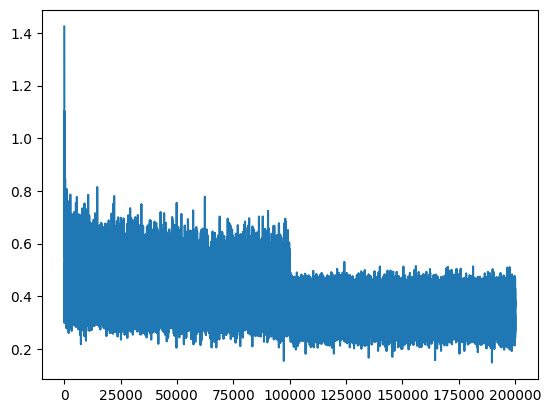

In [260]:
from matplotlib import pyplot as plt
plt.plot(stepi, lossi)

---

In [261]:
emb = C[X_train] # (32, 3, 2)
h = torch.tanh(emb.view(-1, num_inputs) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, y_train)
loss

tensor(2.1797, grad_fn=<NllLossBackward0>)

In [338]:
emb = C[X_dev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, num_inputs) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, y_dev)
loss

tensor(2.1983, grad_fn=<NllLossBackward0>)

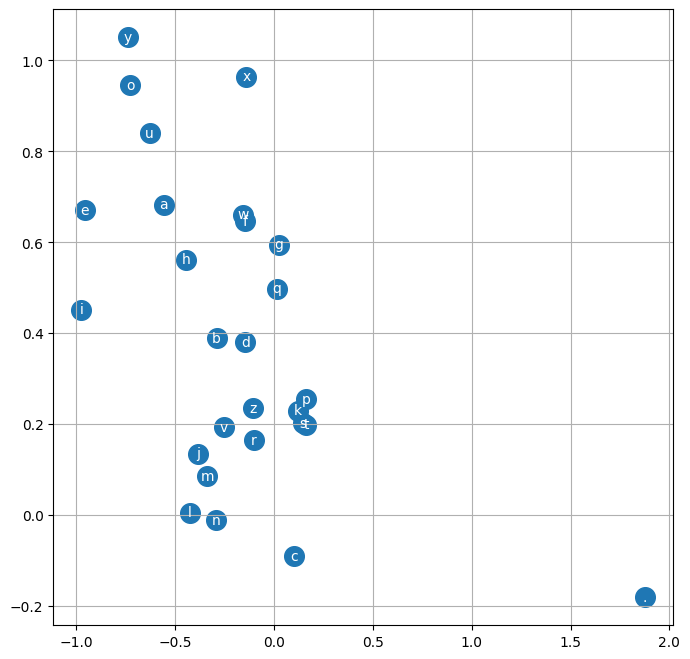

In [263]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
from matplotlib import pyplot as plt


plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

---

In [264]:
emb.view(1, -1)

tensor([[ 1.8768, -0.1808,  0.1652,  ...,  0.4750,  0.4393,  0.5212]],
       grad_fn=<ViewBackward0>)

In [319]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * context_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=None).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

clikaano.
aritah.
cesan.
sekcyn.
shaylah.
gonygesle.
katritp.
kasing.
ashi.
khiah.
salynn.
ayloshe.
komey.
dahlan.
caylie.
elbolah.
rayden.
shian.
jezboin.
yanedha.


---